# PageRank: Flaws and Fixes

## Introduction

The PageRank algorithm has had a tremendous impact on the structure of the internet and the way in which websites are designed. At the time of the algorithm's creation, the most state-of-the-art search engines were highly susceptible to spam and artificial optimization. However, the robustness of the new PageRank algorithm made these techniques fundamentally obsolete and allowed searching the Internet to once again become a viable prospect. Without this taming effect, the many benefits that have been derived from the internet may not have been realized, including social media, online knowledge repositories, and even the entire field of data science.

However, PageRank lent itself well to a new style of search engine optimization, and a whole industry sprung up around it as a result. While many techniques that increased the reputation of a webpage were legitimate, some were able to take advantage of fundamental properties of the algorithm itself, thereby resulting in common website layout idioms that spread throughout the Internet. As these adversarial methods proliferated, the algorithm itself was forced to adapt to become even more robust.

### Tutorial Content

In this tutorial, we will discuss the adversarial inputs to, and evolution of, the PageRank algorithm. We will be using several libraries to illustrate this narrative, with a particular reliance on the [NetworkX Graph Library][networkx] and [Matplotlib][matplotlib]. The tutorial is broken up into the following sections.

* [Recap of PageRank](#rop)
* [Adversarial Website Layouts](#awl)
* [A Variation on PageRank](#vop)
* [Conclusion and References](#car)

[networkx]: https://networkx.github.io/
[matplotlib]: http://matplotlib.org/

## Recap of PageRank <a class="anchor" id="rop"></a>

Before we discuss the details of adversarial inputs to the PageRank technique, we must first review its original definition. The PageRank algorithm was designed by Sergey Brin and Larry Page, the founders of Google, to give each web page on the internet a ranking so that search engine results could display the most relevant content in a more robust manner than previous search engines. This is done by treating the internet as a massive graph being traversed by an imagined "random surfer". As described in [the original paper on PageRank][google-paper], this surfer randomly clicks on links given a random page, with the option to a request an entirely new random page. In this model, the PageRank of a page is the probability that the surfer visits a page, and the damping factor is the probability with which the surfer requests a new page without a link.

We now present a standard implementation of PageRank in Python on an example graph. As opposed to normalizing the PageRank values in a graph to sum to 1.0, as is often done, we return the non-normalized PageRank values, as this makes it easier to see the results of adversarial manipulation.

[google-paper]: http://infolab.stanford.edu/~backrub/google.html

In [6]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

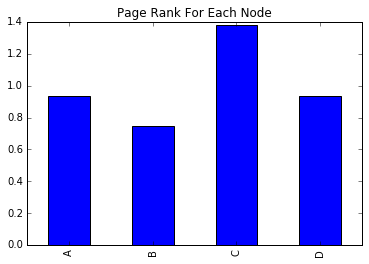

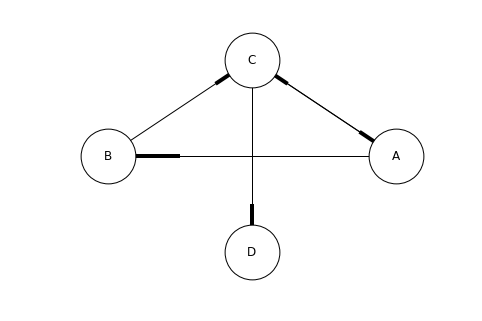

In [7]:
def pagerank(G, d=0.85, iters=100):
    # create adjacency matrix
    A,nodes = nx.adjacency_matrix(G).T, G.nodes()
    n = len(nodes)

    # create vector of length n with each value (1-d)
    scale = (1-d)*np.ones(A.shape[0])
    # set nodes with no out edges to 1
    scale[sp.find(A.sum(axis=0) == 0)[1]] = 1.0
    # create matrix with above as diagonal
    D = sp.diags(scale)
    # normalize columns of A
    P = A*sp.diags(1/np.maximum(np.asarray(A.sum(axis=0))[0], 1e-2))

    #initialize probability vector
    x = np.ones(n)
    for t in range(iters):
        #iteratively update probability vector
        x = d*(P*x) + (np.ones(n)/n)*(np.sum(D*x))

    # return dictionary of results
    return {k:i for k,i in zip(nodes, x)}

G = nx.DiGraph()
G.add_edges_from([("A","B"),("B","C"),("C","A"),("A","C"),("C","D")])
pd.Series(pagerank(G), name="Page Rank").plot(kind='bar',title='Page Rank For Each Node')
plt.show()
nx.draw_circular(G,with_labels=True,node_color='w',node_size=3000)
plt.show()

## Adversarial Website Layouts <a class="anchor" id="awl"></a>

Despite the algorithm's substantial level of correctness, many website owners found various ways to set up adversarial scenarios that artifically inflate the rank of a particular page. We will now detail two of these techniques and provide examples.

### Artificial Home Links

Since the PageRank results vector forms a probability distribution over all possible web pages, a given graph will always have an average page rank of 1.0 (at best). However, since the page rank of an indvidual node gets higher if many nodes have edges to it, a webmaster can set up their site to have many throwaway pages link back to the home page. This results in each of the throwaway pages having low ranks, but the home page (notably, the page most relevant to search results) ends up having an extremely high page rank (when ranks are not normalized).

Consider the following example, as described in Ian Rogers' [Page Rank Explained][page-rank-site], which has homepage A, subpage B, and throwaway pages S1 through S1000.

[page-rank-site]: http://www.cs.princeton.edu/~chazelle/courses/BIB/pagerank.htm

PageRank Results with 1000 Spam Pages
A: 331.087516976, B: 281.574315148, Spam Page: 0.389338167876

PageRank Results with 5000 Spam Pages
A: 1652.75925662, B: 1404.99499642, Spam Page: 0.388849149392

Graph with 4 Artificial Home Links


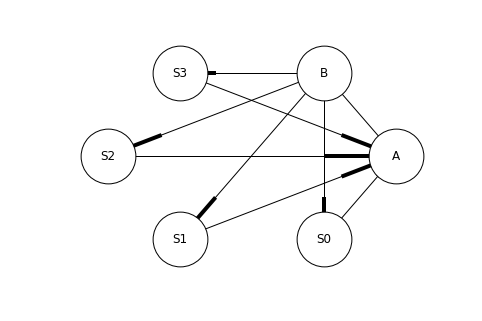

In [8]:
def spam_net(spam_n):
    spam_graph = nx.DiGraph()
    sub_to_throwaway = [("B","S%d" % i) for i in xrange(0,spam_n)]
    throwaway_to_home = [("S%d" % i, "A") for i in xrange(0,spam_n)]
    edges = [("A","B")]
    edges.extend(sub_to_throwaway)
    edges.extend(throwaway_to_home)
    spam_graph.add_edges_from(edges)
    return spam_graph

results = pagerank(spam_net(1000))
print "PageRank Results with 1000 Spam Pages"
print "A: %s, B: %s, Spam Page: %s" % (str(results['A']), str(results['B']), str(results['S0']))
results = pagerank(spam_net(5000))
print "\nPageRank Results with 5000 Spam Pages"
print "A: %s, B: %s, Spam Page: %s" % (str(results['A']), str(results['B']), str(results['S0']))
print "\nGraph with 4 Artificial Home Links"
nx.draw_circular(spam_net(4),with_labels=True,node_color='w',node_size=3000)
plt.show()

We note that as the number of spam pages increases, the rank of the target page increases dramatically while each spam page's rank stays relatively the same. Since the algorithm itself directly supports this type of strategy, while the PageRank algorithm was still in use, Google alleviated this by finding these sorts of hierarchical layouts with bots and thereby flagging them as spam. 

### Link Farms

As a natural extension to the procedure of adding artificial home links, another prominent way of artifically inflating a site's PageRank is by way of a construct called a _link farm_. As presented in the textbook [_Mining of Massive Datasets_][ullman-book], a link farm is a group of websites owned by a spammer that all link to and from a single _target page_. As opposed to the above approach, where the home page links to some intermediary page which then links to each of the spam pages, this approach directly connects the target page to each spam page. This allows the page rank of the home page to climb even higher than it could in the earlier scenario.

We now motivate the effect of a link farm by way of an example. Consider the following traditional website layout.

[ullman-book]: http://infolab.stanford.edu/~ullman/mmds/ch5.pdf

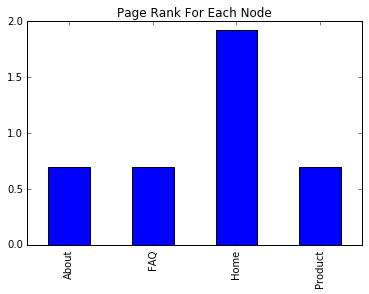

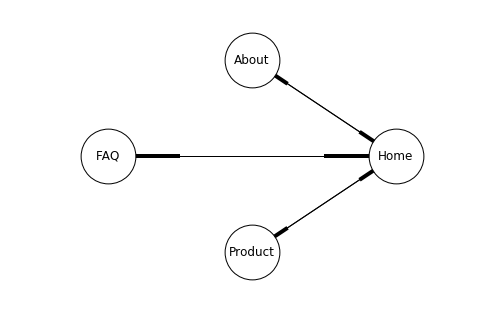

In [9]:
def naive_site():
    naive_graph = nx.DiGraph()
    edges = [("Home", "About"), ("About", "Home"), ("Home", "Product"), ("Product","Home"), 
             ("Home","FAQ"),("FAQ","Home")]
    naive_graph.add_edges_from(edges)
    return naive_graph

G1 = naive_site()
pd.Series(pagerank(G1), name="Page Rank").plot(kind='bar',title='Page Rank For Each Node')
plt.show()
nx.draw_circular(G1,with_labels=True,node_color='w',node_size=3000)
plt.show()

As seen above, our example site has a simple structure, where each sub-page links to and from the home page. This layout gives each sub-page an equal page rank of 0.69 and the home page a page rank of 1.92.

Now suppose our website is picked up by a news site that sets up a link to them. This now boosts the page rank of each page in our example site.

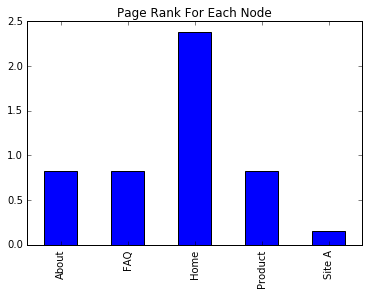

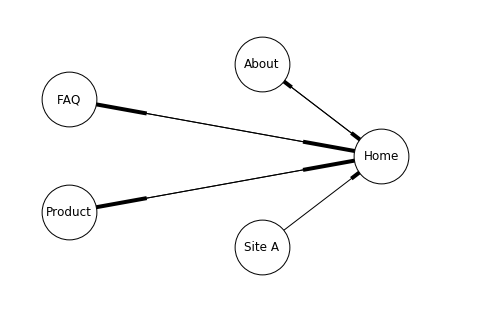

In [10]:
G2 = naive_site()
G2.add_edge("Site A", "Home")
pd.Series(pagerank(G2), name="Page Rank").plot(kind='bar',title='Page Rank For Each Node')
plt.show()
nx.draw_circular(G2,with_labels=True,node_color='w',node_size=3000)
plt.show()

We now suppose the sneaky webmaster of our example site gets excited by the increase in page rank and wants to make our site even more prominent by setting up a link farm. In such a scenario, our example website now has hidden links to each page in the farm, and in return, each page in the farm links to our home page. We now show the effect of a link farm of 4 nodes.

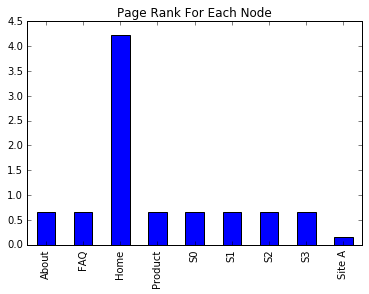

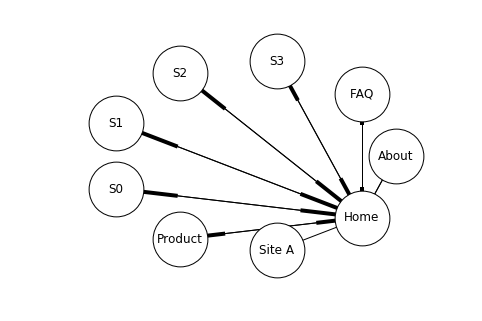

In [11]:
def link_farm_site(n=4):
    G = naive_site()
    spam_nodes = []
    for i in range(n):
        spam_nodes.extend([("S%d" % i, "Home"), ("Home", "S%d" % i)])
    G.add_edges_from(spam_nodes)
    return G
    
G3 = link_farm_site()
G3.add_edge("Site A", "Home")
pd.Series(pagerank(G3), name="Page Rank").plot(kind='bar',title='Page Rank For Each Node')
plt.show()
nx.draw_circular(G3,with_labels=True,node_color='w',node_size=3000)
plt.show()

As we can see above, the rank of our home page has risen from 2.37, in our scenario without a farm, to 4.22, when a farm is introduced. 

We now see that as a link farm grows, so too does the effect on the target page of the farm. Therefore, we now examine the effect on our example site as the farm grows larger, and furthermore, compare this to the effect of the earlier approach (that is, the result of having an intermediary page handling the spam links).

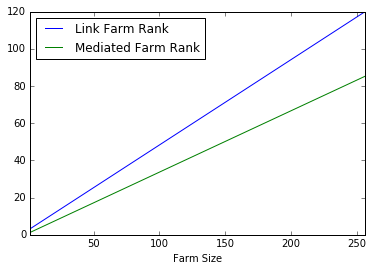

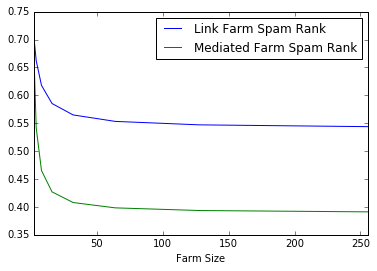

In [12]:
def compare():
    farms = {'Farm Size':[], 'Link Farm Rank':[], 'Link Farm Spam Rank':[], 
             'Mediated Farm Rank':[], 'Mediated Farm Spam Rank':[]}
    for i in np.logspace(1,8, num=8, base=2, dtype=int):
        farms['Farm Size'].append(i)
        G4 = link_farm_site(n=i)
        G4.add_edge("Site A", "Home")
        farms['Link Farm Rank'].append(pagerank(G4)['Home'])
        farms['Link Farm Spam Rank'].append(pagerank(G4)['S0'])
        PR = pagerank(spam_net(i))
        farms['Mediated Farm Rank'].append(PR['A'])
        farms['Mediated Farm Spam Rank'].append(PR['S0'])
    fdf = pd.DataFrame(farms)
    fdf.plot('Farm Size',['Link Farm Rank','Mediated Farm Rank'])
    fdf.plot('Farm Size',['Link Farm Spam Rank','Mediated Farm Spam Rank'])

compare()


As we can see above, the presence of the mediating page significantly limits the amount of page rank available in the system that is able to be given to the homepage. However, in a practical setting, it may be harder for a home page to have a significant number of inobtrusive links directly to spam pages than it would be for it to have a single hidden link to a page with many links. Despite the difference between the two approaches, however, both are quite effective at artificially boosting the rank of a given page under the traditional PageRank algorithm.

## A Variation on PageRank <a class="anchor" id="vop"></a>

As seen in the previous section, inherent assumptions in the PageRank algorithm allow the rank of given pages to be manipulated. Therefore, efforts have been made to improve the algorithm itself to limit the effectiveness of these adversarial techniques. Here, we discuss the motivation behind one such modification, as well as its implementation and its application to the adversarial approaches above.

### Topic-Sensitive PageRank

In the original algorithm, it is equally likely for a "random surfer" to jump to an arbitrary page without using a link. However, this does not accurately model a real surfer, as an actual user is more likely to jump to a page on a related topic to their current page than they are to jump to an unrelated page. Therefore, the Topic-Sensitive PageRank algorithm was established to better model this tendency (as defined in [_Mining of Massive Datasets_][ullman-book]).

Suppose we have the same graph as in the recap section, but here, our surfer prefers some topic _T_ that is covered by pages _B_ and _D_. Therefore, rather than updating the probability vector _x_ with a vector of ones, we update it with a vector where only those indices that represent pages of preferred topics are non-zero. We now show the updated code for this situation, as well as its effect on the initial example graph, noting that node _A_ is now ranked far lower than it was before and that _B_ and _D_ are ranked significantly higher. 

[ullman-book]: http://infolab.stanford.edu/~ullman/mmds/ch5.pdf

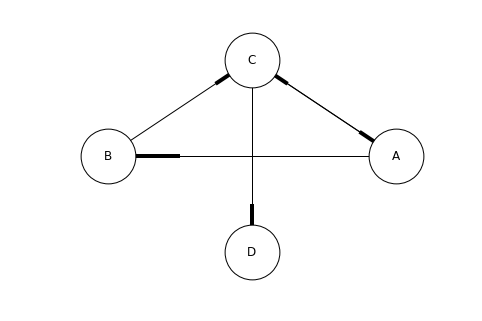

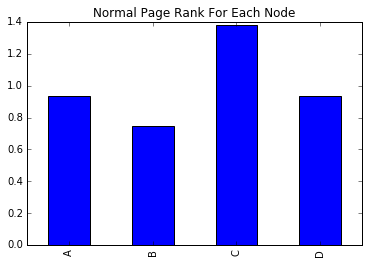

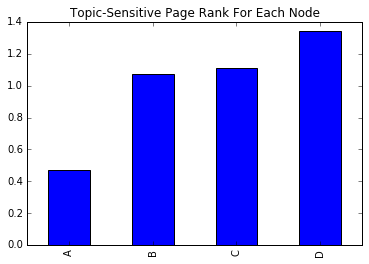

In [14]:
def topic_sensitive_pagerank(G, S, d=0.85, iters=100):
    # create adjacency matrix
    A,nodes = nx.adjacency_matrix(G).T, G.nodes()
    n = len(nodes)

    # create vector of length n with each value (1-d)
    scale = (1-d)*np.ones(A.shape[0])
    # set nodes with no out edges to 1
    scale[sp.find(A.sum(axis=0) == 0)[1]] = 1.0
    # create matrix with above as diagonal
    D = sp.diags(scale)
    # normalize columns of A
    P = A*sp.diags(1/np.maximum(np.asarray(A.sum(axis=0))[0], 1e-2))
    # initialize topic-sensitive vector to have 1.0 for nodes in the teleport set and 0 otherwise
    jump_vector = np.asarray([1.0 if node in S else 0.0 for node in G.nodes()])
    

    #initialize probability vector
    x = np.ones(n)
    for t in range(iters):
        #iteratively update probability vector
        x = d*(P*x) + (jump_vector/len(S))*(np.sum(D*x))

    # return dictionary of results
    return {k:i for k,i in zip(nodes, x)}

# let S be the teleport set
S = {"B","D"}
nx.draw_circular(G,with_labels=True,node_color='w',node_size=3000)
plt.show()
pd.Series(pagerank(G), name="Page Rank").plot(kind='bar',title='Normal Page Rank For Each Node')
plt.show()
pd.Series(topic_sensitive_pagerank(G, S), name="Page Rank").plot(kind='bar',title='Topic-Sensitive Page Rank For Each Node')
plt.show()

### TrustRank for Combatting Link Farms

We can now use the Topic-Sensitive PageRank algorithm to protect against the effects caused by link farms. To do so, we use a particular formulation called TrustRank, where the "topic" provided to the algorithm is the set of pages determined to be trustworthy and therefore not spam.

As described in [_Mining of Massive Datasets_][ullman-book], the set of trustworthy sites is usually decided either manually (i.e., by human curators), or by selecting sites in controlled domains, such as .edu or .gov.

However, the effect of the TrustRank modification can only be observed on much larger-scale graphs than we can reasonably represent here, so we are unable to provide a small representative example.

[ullman-book]: http://infolab.stanford.edu/~ullman/mmds/ch5.pdf

## Conclusion and References <a class="anchor" id="car"></a>

This tutorial discussed the traditional PageRank algorithm, a few ways in which adversarial page layouts can be constructed, and one particular way the algorithm can be made more robust. If the reader would like to learn more, additional information can be found in the links scattered throughout, as well as in the references included below.

* The original PageRank/Google paper: http://infolab.stanford.edu/~backrub/google.html
* An explanation of PageRank by Ian Rogers: http://www.cs.princeton.edu/~chazelle/courses/BIB/pagerank.htm
* PageRank's effect on the web: http://searchengineland.com/rip-google-pagerank-retrospective-244286
* Harchol-Balter, Mor. Performance Modeling and Design of Computer Systems. pp. 190-195
* Leskovec, Rajaraman, and Ullman. Mining of Massive Datasets. pp. 163-200
* Link Farms: https://en.wikipedia.org/wiki/Link_farm